## Importing the necessary libraries

In [1]:
{
    "tags": [
        "hide-input",
    ]
}

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.cbook import boxplot_stats

#!pip install seaborn
import seaborn as sns

#!pip install lightgbm
from lightgbm import LGBMClassifier, LGBMRegressor

#!pip install catboost
from catboost import CatBoostClassifier, CatBoostRegressor

#!pip install umap-learn
from umap import UMAP

#!pip install faiss-cpu
import faiss

import numpy as np
import pandas as pd

from sklearn.metrics import (f1_score, mean_squared_error, accuracy_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve)
                             
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor



import math 

from tqdm import tqdm

#pd.set_option('display.max_rows', 10)
#pd.set_option('display.max_columns', 10)
#pd.set_option('display.width', 10)


#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=10_000)
#torch.set_printoptions(linewidth=200)

# Tabular Data

In [2]:
train_dataset_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\train.csv'
test_dataset_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\test.csv'

In [3]:
try:
    train_dataset = pd.read_csv('train.csv')
    test_dataset = pd.read_csv('test.csv')
except:
     train_dataset = pd.read_csv(train_dataset_local)
     test_dataset = pd.read_csv(test_dataset_local)

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


In [5]:
train_dataset.head(2)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586


In [6]:
test_dataset.head(2)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.046997,368,NaN,14.0,64819$1396468
1,64819,1396235,38,0.046997,368,NaN,14.0,64819$1396235


In [7]:
print(len(train_dataset)) # rows in training dataset
print(len(test_dataset)) # rows in testing dataset

2518441
363835


In [8]:
# checking balance
sum(train_dataset['target'])/train_dataset.shape[0]

0.11699420395395406

In [9]:
train_dataset['target'].value_counts()

0    2223798
1     294643
Name: target, dtype: int64

The dataset is very unbalanced: only 11,70% is positive class. So an F1 metric should be used to estimate the results.

### A function to estimate gaps %

In [10]:
def gaps(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16, color = 'skyblue')
            .set_title('Missing values %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('no gaps left  :)  ')

## Checking gaps

### train_dataset gaps

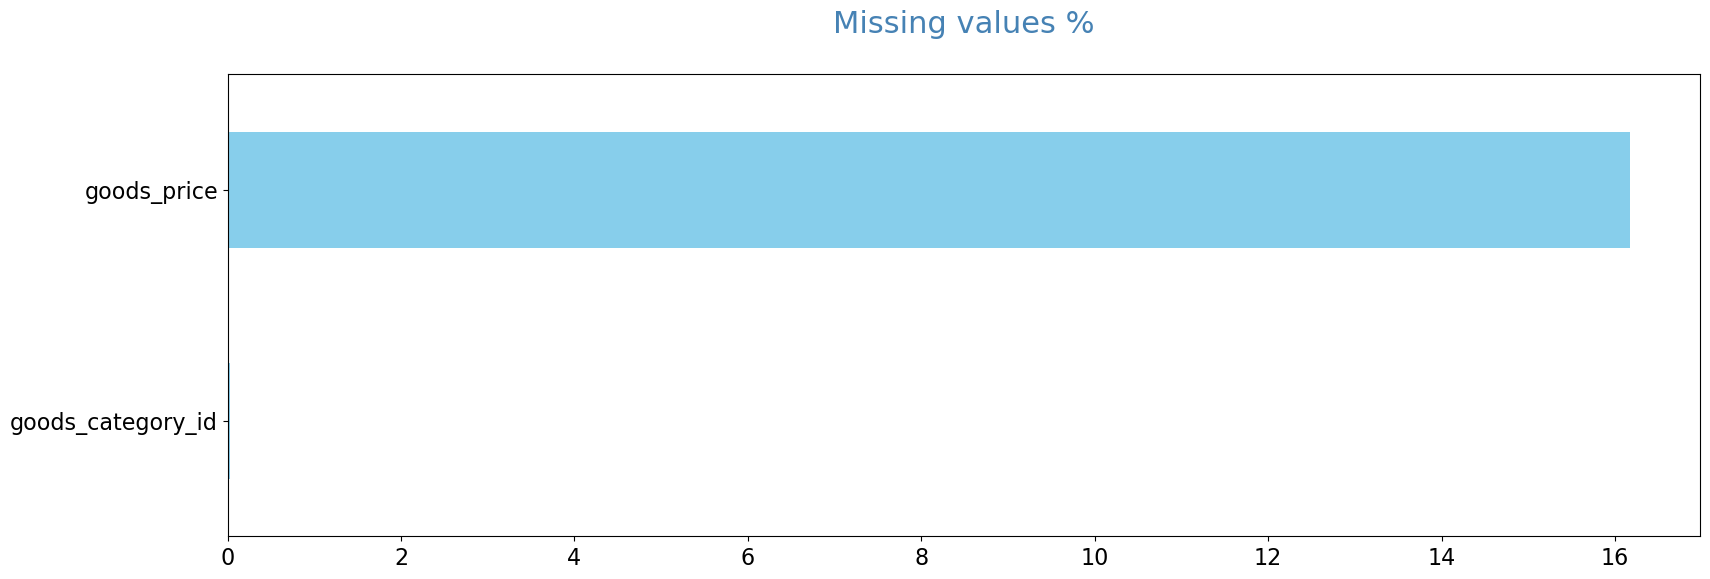

In [11]:
gaps(train_dataset)

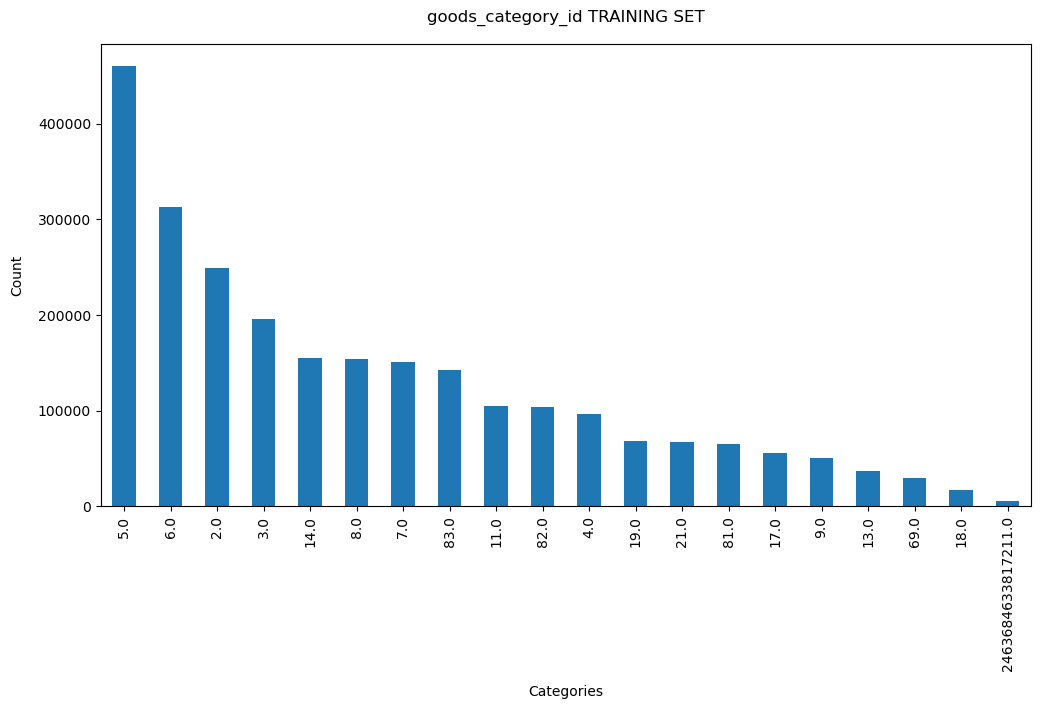

In [12]:
plt.figure(figsize=(12,6))
plt.title('goods_category_id TRAINING SET', y = 1.03) 
train_dataset['goods_category_id'].value_counts().plot(kind='bar')
plt.xlabel('Categories', labelpad=10)
plt.ylabel('Count', labelpad=10)

plt.show()

In [13]:
# filling the missing values in 'goods_category_id' with a random number, for example 99. We'll one-hot codify the data later.
train_dataset['goods_category_id'] = train_dataset['goods_category_id'].fillna(99.0)

In [14]:
# filling gaps with the median by category
for c in train_dataset['goods_category_id'].unique():
    train_dataset.loc[(train_dataset['goods_category_id'] == c) & (train_dataset['goods_price'].isna()), 'goods_price'] = \
    train_dataset.loc[(train_dataset['goods_category_id'] == c), 'goods_price'].median()

no gaps left  :)  


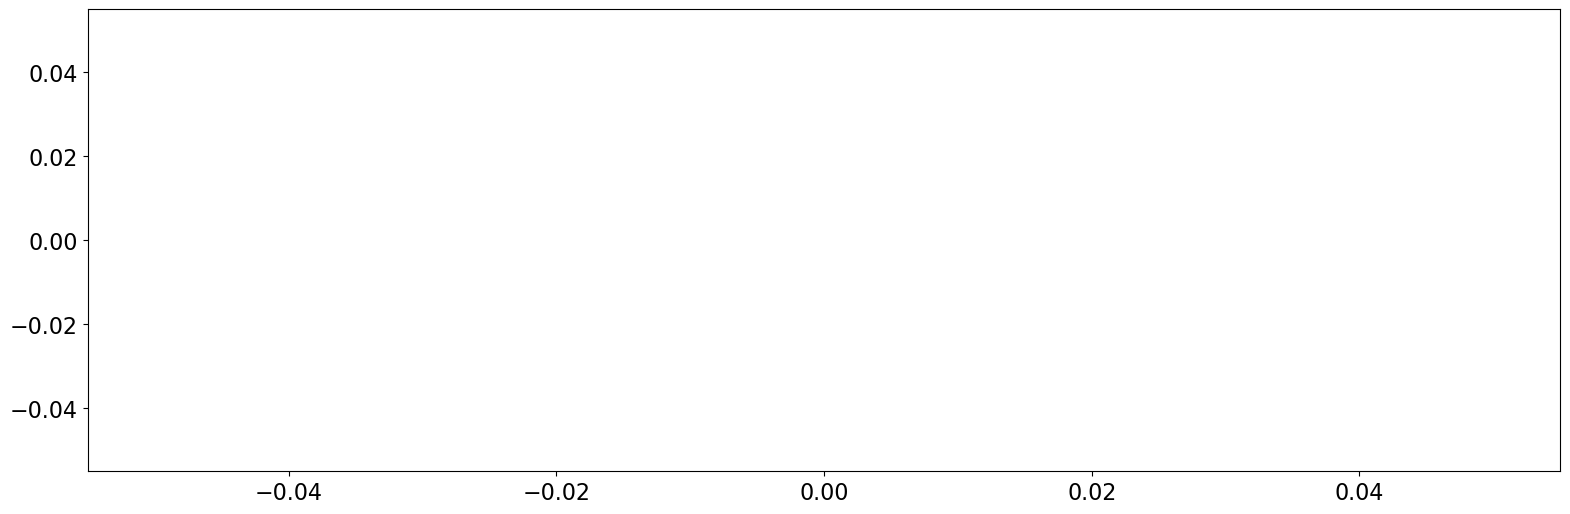

In [15]:
gaps(train_dataset)

### test_dataset gaps

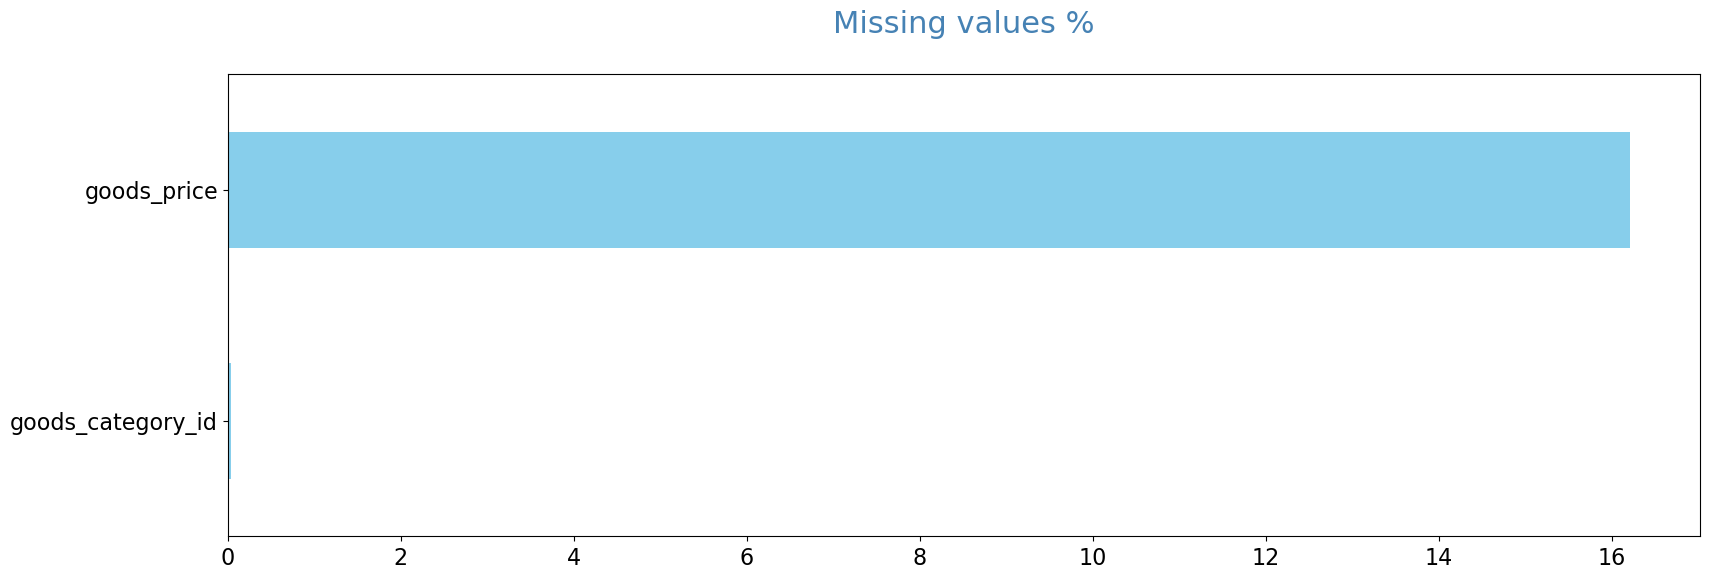

In [16]:
gaps(test_dataset)

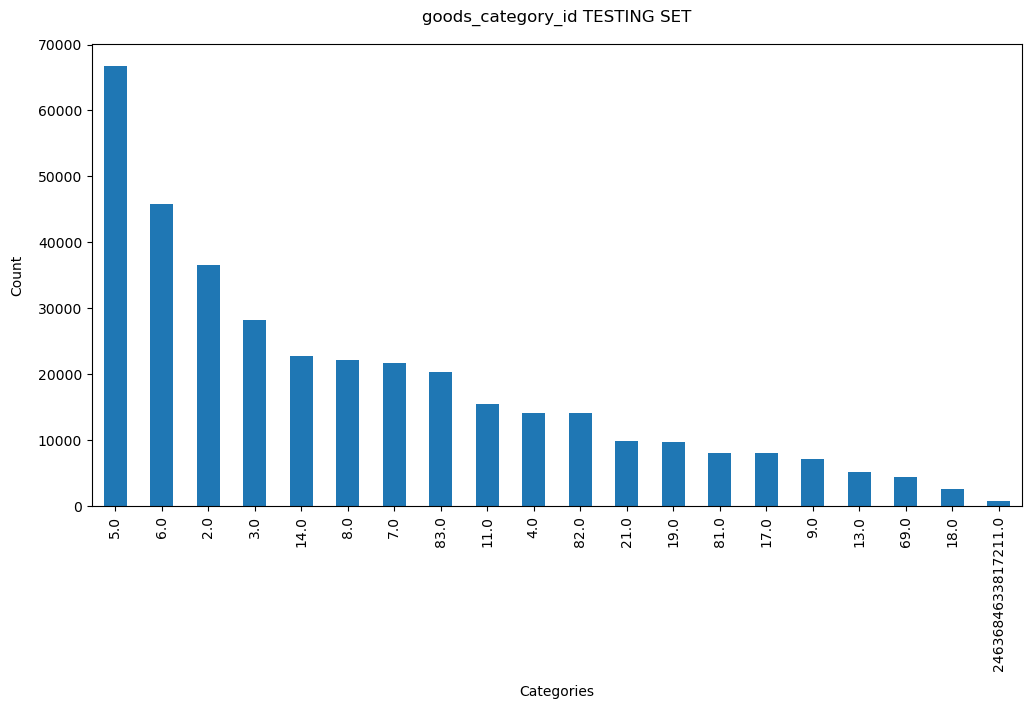

In [17]:
plt.figure(figsize=(12,6))
plt.title('goods_category_id TESTING SET', y = 1.03) 
test_dataset['goods_category_id'].value_counts().plot(kind='bar')
plt.xlabel('Categories', labelpad=10)
plt.ylabel('Count', labelpad=10)
plt.show()

In [18]:
test_dataset['goods_category_id'] = test_dataset['goods_category_id'].fillna(99.0)

In [19]:
for c in test_dataset['goods_category_id'].unique():
    test_dataset.loc[(test_dataset['goods_category_id'] == c) & (test_dataset['goods_price'].isna()), 'goods_price'] = \
    test_dataset.loc[(test_dataset['goods_category_id'] == c), 'goods_price'].median()

no gaps left  :)  


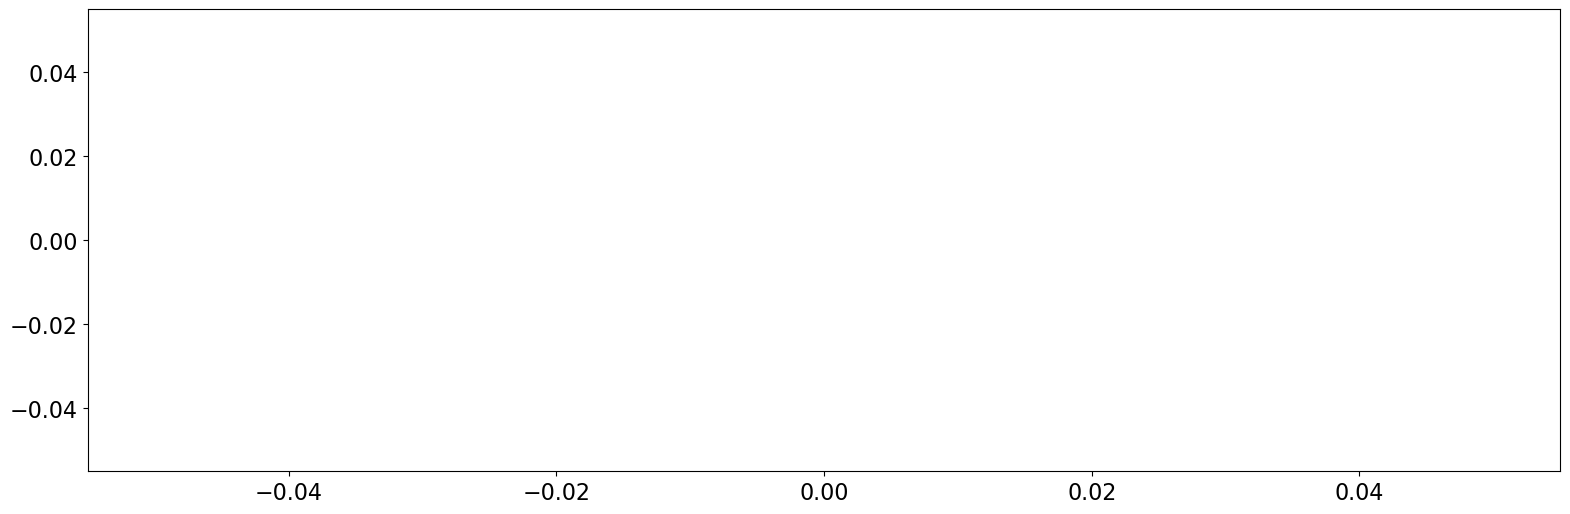

In [20]:
gaps(test_dataset)

## Checking duplicates

### train_dataset duplicates

In [21]:
print(train_dataset.duplicated().sum())
print(train_dataset.duplicated(['goods_depersanalised', 'offer_depersanalised']).sum())
print(train_dataset.duplicated('id').sum())

0
18441
18441


In [22]:
# dropping duplicates 
#train_dataset = train_dataset.drop_duplicates('id')

### test_dataset duplicates

In [23]:
print(test_dataset.duplicated().sum())
print(test_dataset.duplicated(['goods_depersanalised', 'offer_depersanalised']).sum())
print(test_dataset.duplicated('id').sum())

0
0
0


## Correlation

### train_dataset

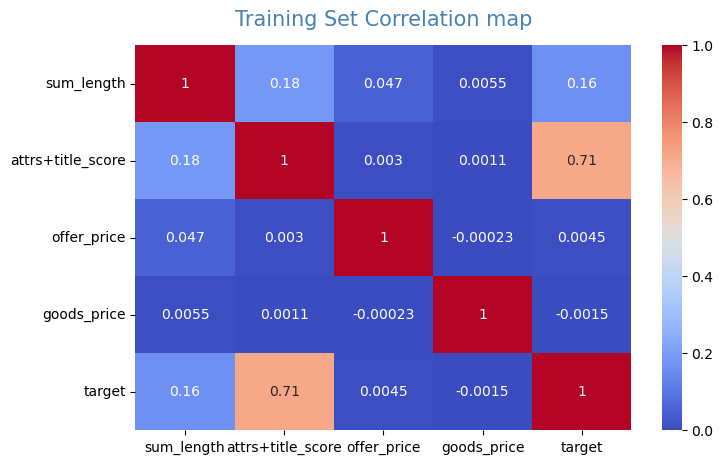

In [24]:
plt.figure(figsize=(8,5))
plt.title('Training Set Correlation map', y = 1.03, fontsize = 15, color = 'SteelBlue')
sns.heatmap(train_dataset.drop(['id','goods_category_id', 'goods_depersanalised', 'offer_depersanalised'], axis=1).corr(), annot=True, cmap = 'coolwarm')
plt.show()

No correlation but `attrs+title_score` with `target` (0.71), but it not significant enough to remove the feature. 

### test_dataset

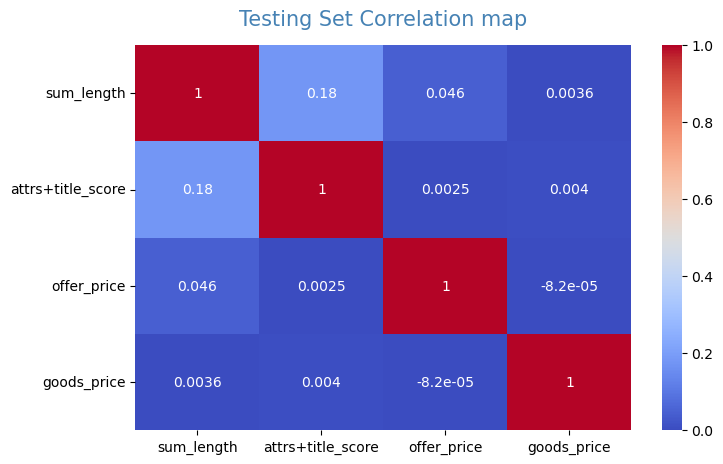

In [25]:
plt.figure(figsize=(8,5))
plt.title('Testing Set Correlation map', y = 1.03, fontsize = 15, color = 'SteelBlue')
sns.heatmap(test_dataset.drop(['id','goods_category_id', 'goods_depersanalised', 'offer_depersanalised'], axis=1).corr(), annot=True, cmap = 'coolwarm')
plt.show()

No correlation.

## Normalization 
The numerical data we have are of very different scales. To improve the quality of the prediction it is better to bring them to the same scale.

In [26]:
for_scaling = ['sum_length', 'attrs+title_score', 'offer_price', 'goods_price'] # features to be scaled

scaler = StandardScaler()

scaler.fit(train_dataset[for_scaling])

scaled_feature_names = scaler.get_feature_names_out()

# scaling training set
train_dataset[for_scaling] = pd.DataFrame(scaler.transform(train_dataset[for_scaling]), columns = scaled_feature_names)

# scaling testing set
test_dataset[for_scaling] = pd.DataFrame(scaler.transform(test_dataset[for_scaling]), columns = scaled_feature_names)

In [27]:
display(train_dataset.head(2))
display(test_dataset.head(2))

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,-1.289479,-0.383736,-0.097729,-0.005516,14.0,0,295140$1396793
1,65291,1396586,-1.287134,-0.296211,-0.097767,-0.005516,14.0,0,65291$1396586


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,-1.287134,-0.309135,-0.097802,-0.005516,14.0,64819$1396468
1,64819,1396235,-1.287134,-0.309135,-0.097802,-0.005516,14.0,64819$1396235


## One-Hot Encoding
The values in `goods_category_id`, even if expressed as integers, represent categories. So that the model does not consider that the higher the number, the more important the category is, we will encode the values using One-Hot.

In [28]:
to_encode = ['goods_category_id'] # the categorical feature to encode

ohe = OneHotEncoder(drop = 'first', handle_unknown = 'infrequent_if_exist') # encoder

In [29]:
ohe.fit(train_dataset[to_encode]) # fitting the encoder

feature_names = ohe.get_feature_names_out()  # saving feature names, since the enocoder returns an np.array with no column names

### Encoding train_dataset

In [30]:
features_array = ohe.transform(train_dataset[to_encode]).toarray()
ohe_features = pd.DataFrame(features_array, columns = feature_names)
train_dataset = train_dataset.drop(to_encode, axis = 1)

train_dataset = train_dataset.reset_index(drop=True)
ohe_features = ohe_features.reset_index(drop=True)

train_dataset = train_dataset.join(ohe_features, how = 'outer')
display(train_dataset.head(2))

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,target,id,goods_category_id_3.0,goods_category_id_4.0,...,goods_category_id_17.0,goods_category_id_18.0,goods_category_id_19.0,goods_category_id_21.0,goods_category_id_69.0,goods_category_id_81.0,goods_category_id_82.0,goods_category_id_83.0,goods_category_id_99.0,goods_category_id_2463684633817211.0
0,295140,1396793,-1.289479,-0.383736,-0.097729,-0.005516,0,295140$1396793,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65291,1396586,-1.287134,-0.296211,-0.097767,-0.005516,0,65291$1396586,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encoding test_dataset

In [31]:
features_array_t = ohe.transform(test_dataset[to_encode]).toarray()
ohe_features_t = pd.DataFrame(features_array_t, columns = feature_names)
test_dataset = test_dataset.drop(to_encode, axis = 1)

test_dataset = test_dataset.reset_index(drop=True)
ohe_features_t = ohe_features_t.reset_index(drop=True)

test_dataset = test_dataset.join(ohe_features_t, how = 'outer')
display(test_dataset.head(2))

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,id,goods_category_id_3.0,goods_category_id_4.0,goods_category_id_5.0,...,goods_category_id_17.0,goods_category_id_18.0,goods_category_id_19.0,goods_category_id_21.0,goods_category_id_69.0,goods_category_id_81.0,goods_category_id_82.0,goods_category_id_83.0,goods_category_id_99.0,goods_category_id_2463684633817211.0
0,64819,1396468,-1.287134,-0.309135,-0.097802,-0.005516,64819$1396468,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64819,1396235,-1.287134,-0.309135,-0.097802,-0.005516,64819$1396235,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Embedding Data

### Defining local paths to access embedding data

In [32]:
# local paths Goods Images
image_goods_embed_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\goods_image_vectors\goods_image_vectors\embed_deperson.npy'
image_goods_items_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\goods_image_vectors\goods_image_vectors\items_deperson.npy'

# local paths Goods Titles
title_goods_embed_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\goods_title_vectors\goods_title_vectors\embed_deperson.npy'
title_goods_items_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\goods_title_vectors\goods_title_vectors\items_deperson.npy'

# local paths Offer Images
image_offer_embed_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\offer_image_vectors\offer_image_vectors\embed_deperson.npy'
image_offer_items_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\offer_image_vectors\offer_image_vectors\items_deperson.npy'

# local paths Offer Titles
title_offer_embed_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\offer_title_vectors\offer_title_vectors\embed_deperson.npy'
title_offer_items_local = r'C:\Users\exeve\OneDrive\Documentos\binary-classification-offers-on-the-marketplace\offer_title_vectors\offer_title_vectors\items_deperson.npy'

### Goods images

In [33]:
try:
    goods_image_embed = np.load(image_goods_embed_local)
    goods_image_items = np.load(image_goods_items_local)
except:
    goods_image_embed = np.load('embed_deperson_image_goods.npy')
    goods_image_items = np.load('items_deperson_image_goods.npy')

### Goods titles

In [34]:
try:
    goods_title_embed = np.load('embed_deperson_title_goods.npy')
    goods_title_items = np.load('items_deperson_title_goods.npy')
    
except:
    goods_title_embed = np.load(title_goods_embed_local)
    goods_title_items = np.load(title_goods_items_local)

### Offer images

In [35]:
try:
    offer_image_embed  = np.load('embed_deperson_image_offer.npy')
    offer_image_items = np.load('items_deperson_image_offer.npy')
except:
    offer_image_embed  = np.load(image_offer_embed_local)
    offer_image_items = np.load(image_offer_items_local)

### Offer titles

In [36]:
try:
    offer_title_embed  = np.load('embed_deperson_title_offer.npy')
    offer_title_items  = np.load('items_deperson_title_offer.npy')
except:
    offer_title_embed  = np.load(title_offer_embed_local)
    offer_title_items  = np.load(title_offer_items_local)

### Checking embeddings shape

In [37]:
print('Dimension of IMAGE embeddings for GOODS', goods_image_embed.shape)
print('Amount of IMAGE embeddings for GOODS', goods_image_items.shape)

print('Dimension of TITLE embeddings for GOODS', goods_title_embed.shape)
print('Amount of TITLE embeddings for GOODS', goods_title_items.shape)

print('Dimension of IMAGE embeddings for OFFER', offer_image_embed.shape)
print('Amount of IMAGE embendings for OFFER', offer_image_items.shape)

print('Dimension of TITLE embeddings for OFFER', offer_title_embed.shape)
print('Amount of TITLE embeddings for OFFER', offer_title_items.shape)

Dimension of IMAGE embeddings for GOODS (317707, 256)
Amount of IMAGE embeddings for GOODS (317707,)
Dimension of TITLE embeddings for GOODS (1760568, 64)
Amount of TITLE embeddings for GOODS (1760568,)
Dimension of IMAGE embeddings for OFFER (457586, 256)
Amount of IMAGE embendings for OFFER (457586,)
Dimension of TITLE embeddings for OFFER (572767, 64)
Amount of TITLE embeddings for OFFER (572767,)


## Reducing Dimension
We're goining to reduce the embeddings dimension via PCA (UMAP is more accurate but requires more resources and it much slower) to 2 components and add the resulting vectors to the datasets as new features to possibly improve the predictions.

#### Reducer

In [38]:
reducer = PCA(n_components=5, random_state = 42)

#### A funtion for changing feature names 
After reducing the dimension, the new columns do not have any naming. In order to successfuly join the reduced embeddings to the main datasets and avoid an error due to that some columns might have the same name (a number in range(len(n_components))), we will rename the columns.  

In [39]:
def change_name_columns(dataset, column_name, first_column_name=None, first_column=False):

    i = 1
    cols = []
        
    if first_column == True:
        
        while i <= (len(dataset.columns)-1):
            cols.append(column_name + str(i))
            i=i+1
        
        cols.insert(0, first_column_name)
    
    else:
        
        while i <= (len(dataset.columns)):
            cols.append(column_name + str(i))
            i=i+1
        
    dataset.columns = cols

#####  goods_image

In [40]:
# reducing the embeddings
goods_image_reduced = pd.DataFrame(reducer.fit_transform(goods_image_embed))

In [41]:
# joining the reduced embeddings with their corresponding ids
goods_image_reduced = pd.DataFrame(goods_image_items, columns=['goods_depersanalised']).join(goods_image_reduced)

In [42]:
# changing 'goods_depersanalised' column data type from str to int to be able
# to merge the reduced embeddings with train_dataset on it

goods_image_reduced['goods_depersanalised'] = goods_image_reduced['goods_depersanalised'].astype('int32')

In [43]:
# changing column names to avoid future errors while merging with train_dataset
change_name_columns(goods_image_reduced, 'goods_image_', first_column_name='goods_depersanalised', first_column=True)

In [44]:
# dropping duplicates
goods_image_reduced = goods_image_reduced.drop_duplicates()
goods_image_reduced = goods_image_reduced.drop_duplicates('goods_depersanalised')

In [45]:
# merging the reduced embeddings with the train_dataset
train_dataset = train_dataset.merge(goods_image_reduced, how='left', on = 'goods_depersanalised')

# test_dataset
test_dataset = test_dataset.merge(goods_image_reduced, how='left', on = 'goods_depersanalised')

##### goods_title

In [46]:
# reducing the embeddings
goods_title_reduced = pd.DataFrame(reducer.fit_transform(goods_title_embed))

In [47]:
# joining the reduced embeddings with their corresponding ids
goods_title_reduced = pd.DataFrame(goods_title_items, columns=['goods_depersanalised']).join(goods_title_reduced)

In [48]:
# changing 'goods_depersanalised' column data type from str to int to be able
# to merge the reduced embeddings with train_dataset on it

goods_title_reduced['goods_depersanalised'] = goods_title_reduced['goods_depersanalised'].astype('int32')

In [49]:
# changing column names to avoid future errors while merging with train_dataset
change_name_columns(goods_title_reduced, 'goods_title_', first_column_name='goods_depersanalised', first_column=True)

In [50]:
# merging the reduced embeddings with the train_dataset
train_dataset = train_dataset.merge(goods_title_reduced, how='left', on = 'goods_depersanalised')

# test_dataset
test_dataset = test_dataset.merge(goods_title_reduced, how='left', on = 'goods_depersanalised')


##### offer_image

In [51]:
# reducing the embeddings
offer_image_reduced = pd.DataFrame(reducer.fit_transform(offer_image_embed))

In [52]:
# joining the reduced embeddings with their corresponding ids
offer_image_reduced = pd.DataFrame(offer_image_items, columns=['offer_depersanalised']).join(offer_image_reduced)

In [53]:
# changing 'goods_depersanalised' column data type from str to int to be able
# to merge the reduced embeddings with train_dataset on it

offer_image_reduced['offer_depersanalised'] = offer_image_reduced['offer_depersanalised'].astype('int32')

In [54]:
# changing column names to avoid future errors while merging with train_dataset
change_name_columns(offer_image_reduced, 'offer_image_', first_column_name='offer_depersanalised', first_column=True)

In [55]:
offer_image_reduced = offer_image_reduced.drop_duplicates()
offer_image_reduced = offer_image_reduced.drop_duplicates('offer_depersanalised')

In [56]:
# merging the reduced embeddings with the train_dataset
train_dataset = train_dataset.merge(offer_image_reduced, how='left', on = 'offer_depersanalised')

# test_dataset
test_dataset = test_dataset.merge(offer_image_reduced, how='left', on = 'offer_depersanalised')

##### offer_title

In [57]:
# reducing the embeddings
offer_title_reduced = pd.DataFrame(reducer.fit_transform(offer_title_embed))

In [58]:
# joining the reduced embeddings with their corresponding ids
offer_title_reduced = pd.DataFrame(offer_title_items, columns=['offer_depersanalised']).join(offer_title_reduced)

In [59]:
# changing 'goods_depersanalised' column data type from str to int to be able
# to merge the reduced embeddings with train_dataset on it

offer_title_reduced['offer_depersanalised'] = offer_title_reduced['offer_depersanalised'].astype('int32')

In [60]:
# changing column names to avoid future errors while merging with train_dataset
change_name_columns(offer_title_reduced, 'offer_title_', first_column_name='offer_depersanalised', first_column=True)

In [61]:
# merging the reduced embeddings with the train_dataset
train_dataset = train_dataset.merge(offer_title_reduced, how='left', on = 'offer_depersanalised')

# test_dataset
test_dataset = test_dataset.merge(offer_title_reduced, how='left', on = 'offer_depersanalised')

In [62]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2518441 entries, 0 to 2518440
Data columns (total 48 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   offer_depersanalised                  int64  
 1   goods_depersanalised                  int64  
 2   sum_length                            float64
 3   attrs+title_score                     float64
 4   offer_price                           float64
 5   goods_price                           float64
 6   target                                int64  
 7   id                                    object 
 8   goods_category_id_3.0                 float64
 9   goods_category_id_4.0                 float64
 10  goods_category_id_5.0                 float64
 11  goods_category_id_6.0                 float64
 12  goods_category_id_7.0                 float64
 13  goods_category_id_8.0                 float64
 14  goods_category_id_9.0                 float64
 15  goods_category_

### Creating a dictionary to join the embeddings to their ids

In [63]:
goods_id2image_embed = {int(k):v for k,v in zip(goods_image_items,goods_image_embed)}
goods_id2title_embed = {int(k):v for k,v in zip(goods_title_items,goods_title_embed)}

offer_id2image_embed = {int(k):v for k,v in zip(offer_image_items,offer_image_embed)}
offer_id2title_embed = {int(k):v for k,v in zip(offer_title_items,offer_title_embed)}

### The embeddings are too large to directly fit them into a ML model. We'll create new features that will represent the embeddings: 

#### Train Dataset

In [64]:
# images
img_cos = [] # cosine distance between the embedding vectors
img_l1 = [] # manhattan distance
img_l2 = [] # euclidean distance
img_canb = [] # canberra distance

# titles
tit_cos = [] # cosine distance between the embedding vectors
tit_l1 = [] # manhattan distance
tit_l2 = [] # euclidean distance
tit_canb = [] # canberra distance

for offer_id, goods_id in tqdm(zip(train_dataset['offer_depersanalised'], train_dataset['goods_depersanalised'])):
    try:
        offer_title_embed = offer_id2title_embed[offer_id]
        offer_image_embed = offer_id2image_embed[offer_id]

        goods_title_embed = goods_id2title_embed[goods_id]
        goods_image_embed = goods_id2image_embed[goods_id]

        #features based on image embeddings
        images_cosine = np.inner(offer_image_embed, goods_image_embed)
        images_l2 = np.linalg.norm(offer_image_embed-goods_image_embed)
        images_l1 = np.linalg.norm(offer_image_embed-goods_image_embed, ord=1)
        images_canb = np.sum(np.abs(offer_image_embed-goods_image_embed) / (np.abs(offer_image_embed)+np.abs(goods_image_embed)))

        #features based on title embeddings
        titles_cosine = np.inner(offer_title_embed, goods_title_embed)
        titles_l2= np.linalg.norm(offer_title_embed-goods_title_embed)
        titles_l1 = np.linalg.norm(offer_title_embed-goods_title_embed, ord=1)
        titles_canb = np.sum(np.abs(offer_title_embed-goods_title_embed) / (np.abs(offer_title_embed)+np.abs(goods_title_embed)))

        img_cos.append(images_cosine)
        img_l1.append(images_l1)
        img_l2.append(images_l2)
        img_canb.append(images_canb)
        
        tit_cos.append(titles_cosine)
        tit_l1.append(titles_l1)
        tit_l2.append(titles_l2)
        tit_canb.append(titles_canb)
     
        

    except KeyError:
        img_cos.append(np.NaN)
        img_l1.append(np.NaN)
        img_l2.append(np.NaN)
        img_canb.append(np.NaN)
        tit_cos.append(np.NaN)
        tit_l1.append(np.NaN)
        tit_l2.append(np.NaN)
        tit_canb.append(np.NaN)

2518441it [00:37, 66801.36it/s]


### Adding the new features to train_dataset

In [65]:
train_dataset['img_cos'] = img_cos
train_dataset['img_l1'] = img_l1
train_dataset['img_l2'] = img_l2
train_dataset['img_canb'] = img_canb

train_dataset['tit_cos'] = tit_cos
train_dataset['tit_l1'] = tit_l1
train_dataset['tit_l2'] = tit_l2
train_dataset['tit_canb'] = tit_canb

In [66]:
train_dataset.head(2)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,target,id,goods_category_id_3.0,goods_category_id_4.0,...,offer_title_4,offer_title_5,img_cos,img_l1,img_l2,img_canb,tit_cos,tit_l1,tit_l2,tit_canb
0,295140,1396793,-1.289479,-0.383736,-0.097729,-0.005516,0,295140$1396793,0.0,0.0,...,0.117788,-0.096843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65291,1396586,-1.287134,-0.296211,-0.097767,-0.005516,0,65291$1396586,0.0,0.0,...,0.182252,0.126790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


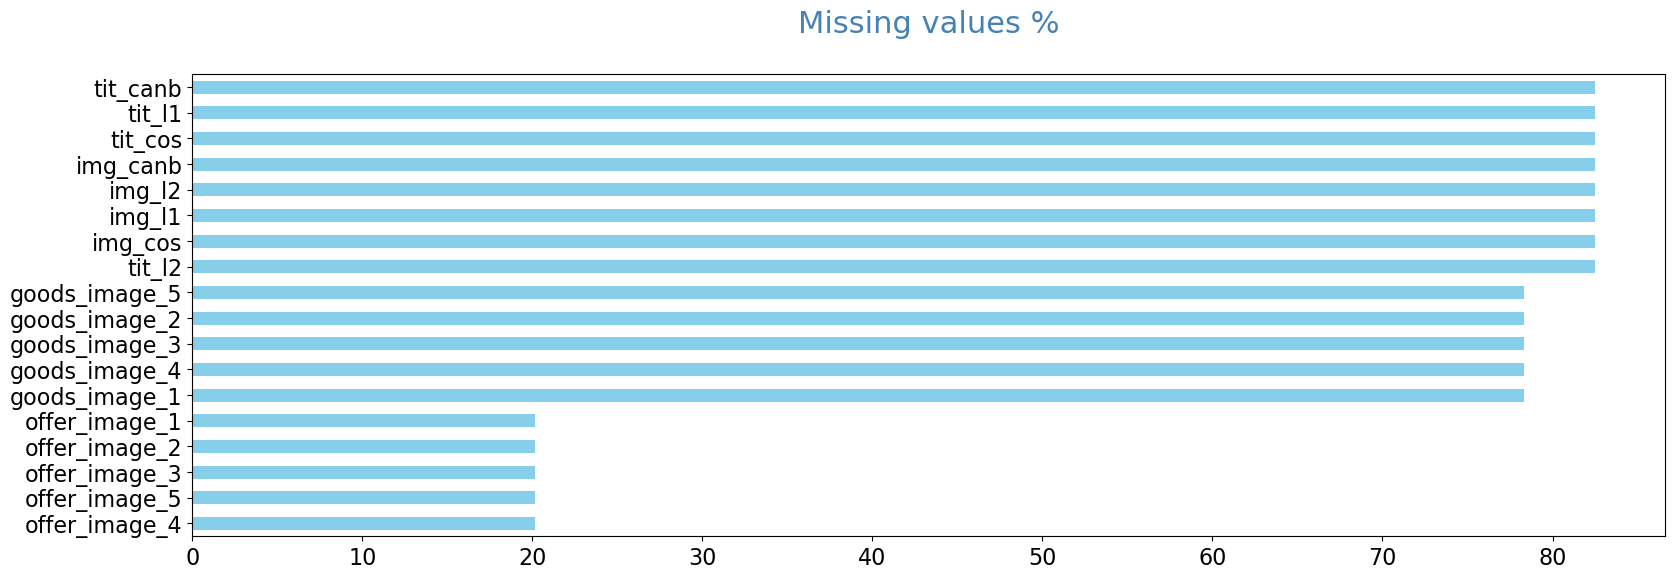

In [67]:
gaps(train_dataset)

#### Test Dataset

In [68]:
# images
img_cos = [] # cosine distance between the embedding vectors
img_l1 = [] # manhattan distance
img_l2 = [] # euclidean distance
img_canb = [] # canberra distance

# titles
tit_cos = [] # cosine distance between the embedding vectors
tit_l1 = [] # manhattan distance
tit_l2 = [] # euclidean distance
tit_canb = [] # canberra distance

for offer_id, goods_id in tqdm(zip(test_dataset['offer_depersanalised'], test_dataset['goods_depersanalised'])):
    try:
        offer_title_embed = offer_id2title_embed[offer_id]
        offer_image_embed = offer_id2image_embed[offer_id]

        goods_title_embed = goods_id2title_embed[goods_id]
        goods_image_embed = goods_id2image_embed[goods_id]

        #features based on image embeddings
        images_cosine = np.inner(offer_image_embed, goods_image_embed)
        images_l2 = np.linalg.norm(offer_image_embed-goods_image_embed)
        images_l1 = np.linalg.norm(offer_image_embed-goods_image_embed, ord=1)
        images_canb = np.sum(np.abs(offer_image_embed-goods_image_embed) / (np.abs(offer_image_embed)+np.abs(goods_image_embed)))

        #features based on title embeddings
        titles_cosine = np.inner(offer_title_embed, goods_title_embed)
        titles_l2= np.linalg.norm(offer_title_embed-goods_title_embed)
        titles_l1 = np.linalg.norm(offer_title_embed-goods_title_embed, ord=1)
        titles_canb = np.sum(np.abs(offer_title_embed-goods_title_embed) / (np.abs(offer_title_embed)+np.abs(goods_title_embed)))

        img_cos.append(images_cosine)
        img_l1.append(images_l1)
        img_l2.append(images_l2)
        img_canb.append(images_canb)
        
        tit_cos.append(titles_cosine)
        tit_l1.append(titles_l1)
        tit_l2.append(titles_l2)
        tit_canb.append(titles_canb)
     
        

    except KeyError:
        img_cos.append(np.NaN)
        img_l1.append(np.NaN)
        img_l2.append(np.NaN)
        img_canb.append(np.NaN)
        tit_cos.append(np.NaN)
        tit_l1.append(np.NaN)
        tit_l2.append(np.NaN)
        tit_canb.append(np.NaN)

363835it [00:05, 68092.80it/s] 


### Adding the new features to test_dataset

In [69]:
test_dataset['img_cos'] = img_cos
test_dataset['img_l1'] = img_l1
test_dataset['img_l2'] = img_l2
test_dataset['img_canb'] = img_canb

test_dataset['tit_cos'] = tit_cos
test_dataset['tit_l1'] = tit_l1
test_dataset['tit_l2'] = tit_l2
test_dataset['tit_canb'] = tit_canb

In [70]:
test_dataset.head(2)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,id,goods_category_id_3.0,goods_category_id_4.0,goods_category_id_5.0,...,offer_title_4,offer_title_5,img_cos,img_l1,img_l2,img_canb,tit_cos,tit_l1,tit_l2,tit_canb
0,64819,1396468,-1.287134,-0.309135,-0.097802,-0.005516,64819$1396468,0.0,0.0,0.0,...,0.055367,-0.041248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64819,1396235,-1.287134,-0.309135,-0.097802,-0.005516,64819$1396235,0.0,0.0,0.0,...,0.055367,-0.041248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


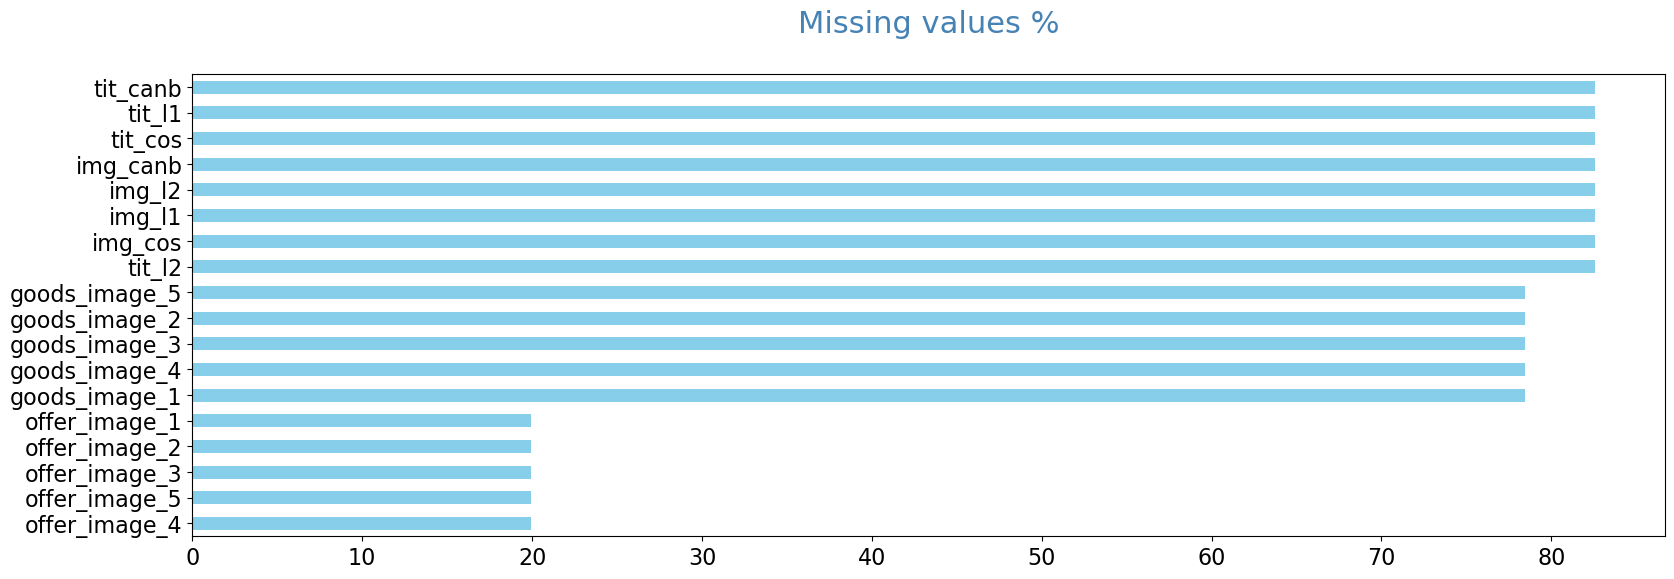

In [71]:
gaps(test_dataset)

## A couple of additional features (differences between the offer and goods prices)

In [72]:
# train
train_dataset['price_abs_diff'] = train_dataset.apply(lambda row: abs(row['offer_price']-row['goods_price']), axis=1)
train_dataset['price_diff'] = train_dataset.apply(lambda row: row['offer_price']/row['goods_price'] if row['goods_price'] !=0 else 9999, axis=1)

# test
test_dataset['price_abs_diff'] = test_dataset.apply(lambda row: abs(row['offer_price']-row['goods_price']), axis=1)
test_dataset['price_diff'] = test_dataset.apply(lambda row: row['offer_price']/row['goods_price'] if row['goods_price'] !=0 else 9999, axis=1)

### Splitting train_dataset into training and validation samples 

In [73]:
train_x, valid_x, train_y, valid_y = train_test_split(train_dataset.drop(['offer_depersanalised',
                                                                          'goods_depersanalised',
                                                                          'target',
                                                                          'id'], axis = 1),
                                                                          
                                                      
                                                                train_dataset['target'],
                                                      
                                                                test_size=0.15,
                                                      
                                                                random_state=42)

# LightGBM (Base Model 1)

In [74]:
%%time

lgbm = LGBMClassifier(random_state = 42,
                      objective = 'binary',
                      num_iterations = 1500)                   
                

lgbm.fit(train_x, train_y)
lgbm_pred = lgbm.predict(valid_x)
lgbm_error = f1_score(lgbm_pred, valid_y)
print('F1:', lgbm_error)

C:\Users\exeve\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 250487, number of negative: 1890187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.701280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8710
[LightGBM] [Info] Number of data points in the train set: 2140674, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117013 -> initscore=-2.021024
[LightGBM] [Info] Start training from score -2.021024
F1: 0.9206181945907973
CPU times: total: 13min 33s
Wall time: 4min 56s


# CatBoost (Base Model 2)

In [75]:
%%time

cat = CatBoostClassifier(
    verbose = 200,
    iterations = 1500,
    eval_metric = 'F1',
    loss_function = 'Logloss',
    random_state = 42)

cat.fit(train_x, train_y)
cat_pred = cat.predict(valid_x)

cat_error = f1_score(cat_pred, valid_y)
print('F1:', cat_error)

Learning rate set to 0.18776
0:	learn: 0.9085277	total: 604ms	remaining: 15m 6s
200:	learn: 0.9232890	total: 1m 18s	remaining: 8m 27s
400:	learn: 0.9268685	total: 2m 35s	remaining: 7m 5s
600:	learn: 0.9295677	total: 3m 53s	remaining: 5m 48s
800:	learn: 0.9319486	total: 5m 10s	remaining: 4m 30s
1000:	learn: 0.9339278	total: 6m 27s	remaining: 3m 13s
1200:	learn: 0.9358708	total: 7m 43s	remaining: 1m 55s
1400:	learn: 0.9376547	total: 8m 58s	remaining: 38.1s
1499:	learn: 0.9386466	total: 9m 36s	remaining: 0us
F1: 0.9236946019280404
CPU times: total: 30min 1s
Wall time: 9min 39s


# Neural Network Model (Base Model 3)

In [76]:
train_x_filled = train_x.fillna(0)
valid_x_filled = valid_x.fillna(0)

## Hyperparameters 

In [77]:
epochs = 11
batch_size = 128
learning_rate = 0.001

## Loading data in batches
The datasets size is too large for the NN to process it all at once. It's better to load the data in batches.

In [78]:
class BinaryDataset(Dataset):
    
    def __init__(self, feature_array, target_array):
        
        self.feature_array = np.array(feature_array)      
        self.target_array = np.array(target_array)
        
        
        
                                  
    def __getitem__(self, index):
        
        x = torch.tensor(self.feature_array[index], dtype=torch.float)
        y = torch.tensor(self.target_array[index], dtype=torch.float)
                                    
        return x,y
    
                                  
    def __len__(self):
        
        return len(self.feature_array)

In [79]:
class TestDataset(Dataset):
    
    def __init__(self, feature_array):
        
        self.feature_array = np.array(feature_array)      
              
                                  
    def __getitem__(self, index):
        
        x = torch.tensor(self.feature_array[index], dtype=torch.float)
      
        return x
    
                                  
    def __len__(self):
        
        return len(self.feature_array)

In [80]:
# mapping datasets

# training and validation datasets
train_dataset_nn = BinaryDataset(train_x_filled, train_y)
val_dataset_nn = BinaryDataset(valid_x_filled, valid_y)


# testing dataset
test_dataset_pred = test_dataset.drop(['offer_depersanalised',
                      'goods_depersanalised',
     
                      'id'], axis = 1)

test_dataset_pred = test_dataset_pred.fillna(0)

test_dataset_nn = TestDataset(test_dataset_pred)

In [81]:
# creating loaders to load the mapped datasets in batches
train_loader_nn = DataLoader(dataset=train_dataset_nn, batch_size = batch_size, shuffle = True)
val_loader_nn = DataLoader(dataset=val_dataset_nn, batch_size = batch_size, shuffle = False)
test_loader_nn = DataLoader(dataset=test_dataset_nn, batch_size = batch_size, shuffle = False)

### A sample of the data

In [82]:
sample = iter(train_loader_nn)

feature, target = next(sample)

print('Feature array:\n\n', feature)
print('')
print('Target array:\n\n', target)


Feature array:

 tensor([[ 1.4720,  1.2191, -0.0954,  ...,  0.0000,  0.0929, 37.7367],
        [ 0.9563, -0.4827, -0.0959,  ...,  0.0000,  0.0931, 34.0273],
        [ 0.5038,  1.4757, -0.0973,  ...,  0.0000,  0.0923, 19.7461],
        ...,
        [-0.9121, -0.4867, -0.0974,  ...,  0.0000,  0.0920, 17.8922],
        [-0.1080, -0.4867, -0.0943,  ...,  0.0000,  0.0891, 18.2607],
        [ 0.6257, -0.4648, -0.0975,  ...,  0.0000,  0.0921, 17.8413]])

Target array:

 tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 

## Model

In [83]:
class LinearModel (nn.Module):
    
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        
        self.linear_stack = nn.Sequential(
            
            nn.Linear(input_size, 512), #1
            nn.ReLU(),
            nn.Linear(512, 1028),  #2
            nn.Dropout(p=0.4),
            nn.Linear(1028, 2056),  #3
            nn.Dropout(p=0.4),
            nn.Linear(2056, 1028),  #4
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(1028, 512),  #5
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(512, 256),  #6
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(256, 1)  #7
        
        )
        
    def forward(self, x):      
        
        output = self.linear_stack(x)
        
        return output

## Device settings

In [84]:
# cuda = use GPU ; cpu = use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


## Initialization of the model

In [85]:
NN = LinearModel(train_x_filled.shape[1]).to(device)

## Loss and Optimizer

In [86]:
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy loss + Sigmoid function
optimizer = optim.Adam(NN.parameters(), lr = learning_rate, weight_decay = 0.01)

# scheduler to adjust Adam after each epoch in full training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = 0.9) 

## Training 1 epoch

In [87]:
def train_epoch(model, loader, optimizer):
    
    model.train()
    steps = len(loader)
    correct = 0
    train_losses = []
    best_acc = - np.inf
    best_weights = None

    for batch_index, (x, target) in enumerate(loader): # loop over the batches

        x = x.to(device)
        target = target.to(device).unsqueeze(dim=1)

        # forward
        prediction = model(x)
        loss = criterion(prediction, target)
        train_losses.append(loss.item())
        
        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()     

        # print progress
        if (batch_index + 1) % 1000 == 0:
            print(f'step {batch_index + 1}/{steps}, loss = {loss.item():.4f}')
            
    return train_losses

In [88]:
train_epoch(NN, train_loader_nn, optimizer)

step 1000/16725, loss = 0.2730
step 2000/16725, loss = 0.3965
step 3000/16725, loss = 0.4435
step 4000/16725, loss = 0.2789
step 5000/16725, loss = 0.2266
step 6000/16725, loss = 0.1874
step 7000/16725, loss = 0.0952
step 8000/16725, loss = 0.4460
step 9000/16725, loss = 0.2170
step 10000/16725, loss = 0.1488
step 11000/16725, loss = 0.2149
step 12000/16725, loss = 0.1429
step 13000/16725, loss = 0.0735
step 14000/16725, loss = 0.3401
step 15000/16725, loss = 0.2223
step 16000/16725, loss = 0.1431


[0.7502579689025879,
 0.9917865991592407,
 0.9480637907981873,
 0.514981746673584,
 1.4811232089996338,
 0.5454698801040649,
 0.4245165288448334,
 0.26199668645858765,
 0.34966841340065,
 0.4765315353870392,
 0.5017486214637756,
 0.46849822998046875,
 0.3849600553512573,
 0.8620049357414246,
 0.5776140689849854,
 0.30935433506965637,
 0.32905182242393494,
 1.7959622144699097,
 0.2883046269416809,
 0.5329868793487549,
 0.31195688247680664,
 0.3012051284313202,
 0.23654808104038239,
 0.24115629494190216,
 0.3442728519439697,
 0.3002977669239044,
 0.3982764184474945,
 0.851039707660675,
 0.29423826932907104,
 0.14411787688732147,
 0.2358684539794922,
 0.2827605605125427,
 0.2956520617008209,
 0.30503061413764954,
 0.29264184832572937,
 0.16141022741794586,
 0.23140200972557068,
 0.8145159482955933,
 0.178097665309906,
 0.30006149411201477,
 0.34108471870422363,
 0.21483854949474335,
 0.3641781508922577,
 0.2430008500814438,
 0.2645527422428131,
 2.1097376346588135,
 0.24503900110721588,
 

## Validating 1 epoch

In [89]:
def validate_epoch(model, loader):
    
    model.eval()
    
    # a function to flatten a list of lists into a single list
    def flatten_extend(matrix):
        flat_list = []
        for row in matrix:
            flat_list.extend(row)
        return flat_list

    test_loss = 0
    correct = 0
    prediction_list = []
    
    with torch.no_grad():      

        for features, target in loader:

            features = features.to(device)
            target = target.to(device).unsqueeze(dim=1)
            
            prediction = model(features)
             
            prediction_list.append(np.array(torch.round(torch.sigmoid(prediction))))
            
            
            test_loss += criterion(prediction, target).item()
            
                   
    print(f'Test Average Loss: {test_loss / len(loader)}')
    
    return test_loss, list(map(int, flatten_extend(prediction_list))) # making the prediction list values integers

In [90]:
v = validate_epoch(NN, val_loader_nn)

Test Average Loss: 0.1601537225015845


In [91]:
nn_pred = v[1]

In [92]:
print('Accuracy:', accuracy_score(nn_pred, valid_y))
print('F1:', f1_score(nn_pred, valid_y))
print('Precision:', precision_score(nn_pred, valid_y))
print('Recall:', recall_score(nn_pred, valid_y))

Accuracy: 0.9650234139032791
F1: 0.8430144831109581
Precision: 0.803446870187517
Recall: 0.886681162680263


## Testing 1 epoch

In [93]:
def test_epoch(model, loader):
    
    model.eval()
    
    # a function to flatten a list of lists into a single list
    def flatten_extend(matrix):
        flat_list = []
        for row in matrix:
            flat_list.extend(row)
        return flat_list

    test_loss = 0
    correct = 0
    prediction_list = []
    
    with torch.no_grad():      

        for features in loader:

            features = features.to(device)
            
            
            prediction = model(features)
             
            prediction_list.append(np.array(torch.round(torch.sigmoid(prediction))))         
        
    
    return list(map(int, flatten_extend(prediction_list))) # making the prediction list values integers

## Full training 
(The F1 score did not change after a full training with 11 epochs, so we're not executing this code again because of the long wait)

'''
train_losses = []
valid_losses = []
valid_preds = []

for epoch in range(epochs):
    
    print(f'Epoch {epoch+1}')
    train_losses += train_epoch(NN, train_loader_nn, optimizer)
    valid_losses.append(validate_epoch(NN, val_loader_nn))
    valid_preds.append(validate_epoch(NN, val_loader_nn)[1])
    scheduler.step()  
    
'''

## Saving model

In [94]:
torch.save(NN, 'NN_bin_class.pt')
torch.save(NN.state_dict(), 'NN_bin_class_weights.pt')

# Gaussian Naive Bayes (Base model 4)

In [96]:
gnb = GaussianNB()
gnb.fit(train_x_filled, train_y)
gnb_pred = gnb.predict(valid_x_filled)
gnb_error = f1_score(gnb_pred, valid_y)
print(gnb_error)

0.6643303689354584


# Bernoulli Naive Bayes (Meta-Model)

## Training the Meta-Model

In [97]:
# Combining the predictions of the base models on the validation set into a single feature matrix
nb_x = np.column_stack((lgbm_pred, cat_pred, gnb_pred, nn_pred))

# Training the meta-model on the combined feature matrix and the target values
nb = BernoulliNB()
nb.fit(nb_x, valid_y)

BernoulliNB()

## Base models predictions on the Testing Dataset

In [98]:
%%time

lgbm_pred_test = lgbm.predict(test_dataset_pred)

CPU times: total: 45.2 s
Wall time: 14 s


In [99]:
%%time

gnb_pred_test = gnb.predict(test_dataset_pred)

CPU times: total: 375 ms
Wall time: 438 ms


In [100]:
%%time

cat_pred_test = cat.predict(test_dataset_pred)

CPU times: total: 1.09 s
Wall time: 805 ms


In [101]:
%%time

nn_pred_test = test_epoch(NN, test_loader_nn)

CPU times: total: 7min 33s
Wall time: 2min 12s


In [102]:
cat_pred_pd = pd.concat([test_dataset['id'], pd.Series(lgbm_pred_test)] , axis = 1)
cat_pred_pd = cat_pred_pd.set_index('id')
cat_pred_pd.to_csv('results_03.csv')

## The final prediction of the Meta-Model taking base models predictions on the Testing Dataset as input

In [103]:
# Combining the predictions of the base models into a single feature matrix
nb_t = np.column_stack((lgbm_pred_test, cat_pred_test, gnb_pred_test, nn_pred_test))

# Training the meta-model on the combined feature matrix and the target values
nb_pred_test = nb.predict(nb_t)

In [104]:
nb_pred_pd = pd.concat([test_dataset['id'], pd.Series(nb_pred_test)] , axis = 1)

In [105]:
nb_pred_pd = nb_pred_pd.set_index('id')

In [106]:
nb_pred_pd.to_csv('results_01.csv') # this gives an F1 score of only 0.78706, which is expectable since the NN and the gnb models are weak

# Conclusion

During the project the following was carried out:
- The data was studied, cleaned and transformed 
- The image & text embeddings were represented as the distance among them
- 20 features were created from the dimension reduction of the embeddings using PCA 
- Additional features were also created from the price difference between the offer and the goods.
- Several ML models were developed and their predictions were stacked into a Bernoulli Naive Bayes meta-model to extract better probabilities. The final Meta-Model's F1 score is just slightly better than the CatBoost model alone, which takes a lot less time to deploy.
- The CatBoost model alone is the most suitable model, due to the speed and scoring.

